In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.decomposition import PCA, FactorAnalysis
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import LabelEncoder

   ID  Q_Age  Q_Gender  Q_City  Q1  Q4  Q7  Q13_1  Q13_2  Q13_3  ...  Q27_5  \
0  18     71         1       4   2   3   3      1      1      0  ...      0   
1  23     65         2       5   1   1   2      1      0      0  ...      0   
2  30     77         1       4   1   1   2      0      0      1  ...      0   
3  31     75         1       4   2   3   3      0      0      1  ...      0   
4  34     73         2       4   1   2   2      1      0      0  ...      0   

   Q27_6  Q27_7  Q27_8  Q27_9  Q27_10  Q28  Q29  Q32  Price_elasticity  
0      0      0      0      0       0    4    2    3          0.299965  
1      0      0      0      0       0    1    2    1          0.039880  
2      0      1      0      0       0    4    2    1         -0.120003  
3      0      1      0      0       0    4    2    2          0.032044  
4      0      1      0      0       0    4    2    6          0.163676  

[5 rows x 42 columns]
(1136, 42)


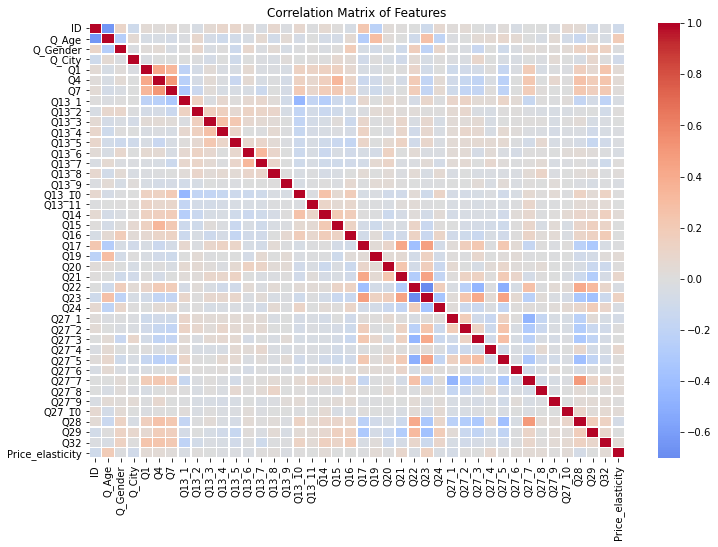

Top 20 correlating feature pairs (|r| < 1):
Feature1 Feature2  Correlation
     Q23      Q22    -0.700303
   Q_Age       ID    -0.640694
      Q7       Q4     0.514710
   Q27_5      Q22    -0.498461
     Q28    Q27_7     0.494290
   Q27_7    Q27_1    -0.467332
     Q23      Q17     0.465333
   Q27_3      Q22    -0.453587
     Q23      Q21     0.447126
  Q13_10    Q13_1    -0.445271
   Q27_5      Q23     0.443799
     Q21      Q17     0.425628
      Q4       Q1     0.418065
     Q28      Q22     0.407228
   Q27_3      Q23     0.406247
     Q22      Q17    -0.387714
     Q28    Q27_5    -0.385802
     Q29      Q23    -0.373753
     Q24      Q23    -0.346694
      Q7       Q1     0.338951
Counts of each class:
0.0    445
1.0    401
Name: is_price_responsive, dtype: int64
Features (X): ['Q_Age', 'Q_Gender', 'Q_City', 'Q1', 'Q4', 'Q7', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q14', 'Q15', 'Q16', 'Q17', 'Q19', 'Q20', 'Q21', 'Q22', 

In [9]:
df = pd.read_csv('survey_PE.csv')

print(df.head())
print(df.shape)

#-------------------------------------------------------CORRELATION MATRIX------------------------------------------------------

corr_matrix = df.corr()

plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, 
            annot = False, 
            fmt = ".2f", 
            cmap = 'coolwarm', 
            center = 0,
            linewidths = 0.5)
plt.title("Correlation Matrix of Features")
plt.show()

upper_triangle = np.triu(np.ones_like(corr_matrix, dtype = bool))

high_corr_pairs = (corr_matrix.where(~upper_triangle)
                  .stack()
                  .reset_index()
                  .rename(columns={'level_0':'Feature1', 'level_1':'Feature2', 0:'Correlation'}))

high_corr_pairs = (high_corr_pairs[abs(high_corr_pairs['Correlation']) < 1]
                  .sort_values(by = 'Correlation', key = abs, ascending = False))

top_n = 20
print(f"Top {top_n} correlating feature pairs (|r| < 1):")
print(high_corr_pairs.head(top_n).to_string(index=False))

#-------------------------------------------------------MAKE TO CLASSIFICATION PROBLEM----------------------------------------------------

threshold = 0.0331
treshold2 = 0.0328

df['is_price_responsive'] = df['Price_elasticity'].apply(
    lambda x: 1 if x < -threshold else (0 if x > treshold2 else None)
)

df = df.dropna(subset = ['is_price_responsive'])

counts = df['is_price_responsive'].value_counts()
print("Counts of each class:")
print(counts)


X = df.drop(columns = ["is_price_responsive", "Price_elasticity", 'ID'])
y = df['is_price_responsive']

print("Features (X):", list(X.columns)) 

print("Target (y):", y.name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 40)

C:\Users\idawh\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.6189972480220158
Selected Features: ('Q_Age', 'Q13_5', 'Q13_6', 'Q13_8', 'Q16', 'Q24', 'Q27_4', 'Q27_10')


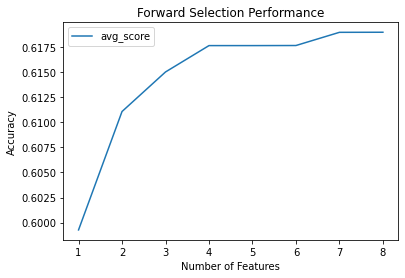

Top 10 Features Fisher Scores:
   Feature  Fisher_Score  Percentile
0    Q_Age      0.037609       100.0
30   Q27_4      0.013517        98.0
2   Q_City      0.012077        95.0
25     Q23      0.008813        92.0
33   Q27_7      0.008227        90.0
27   Q27_1      0.007191        88.0
21     Q19      0.005348        85.0
12   Q13_7      0.005262        82.0
35   Q27_9      0.003924        80.0
20     Q17      0.003420        78.0
Significant Features by Chi-Squared Test (p < 0.05):
   Feature  Chi2_Score       p_value
0    Q_Age   27.167343  1.865839e-07
30   Q27_4    9.855505  1.693243e-03
25     Q23    5.317922  2.110716e-02
33   Q27_7    5.059376  2.449306e-02
12   Q13_7    3.360740  6.676807e-02
21     Q19    3.136123  7.657563e-02
35   Q27_9    2.935639  8.664436e-02
2   Q_City    2.535798  1.112906e-01
27   Q27_1    2.041806  1.530279e-01
36  Q27_10    1.776675  1.825582e-01
29   Q27_3    1.678677  1.951003e-01
20     Q17    1.547190  2.135507e-01
4       Q4    0.935484  3.33

<Figure size 864x576 with 0 Axes>

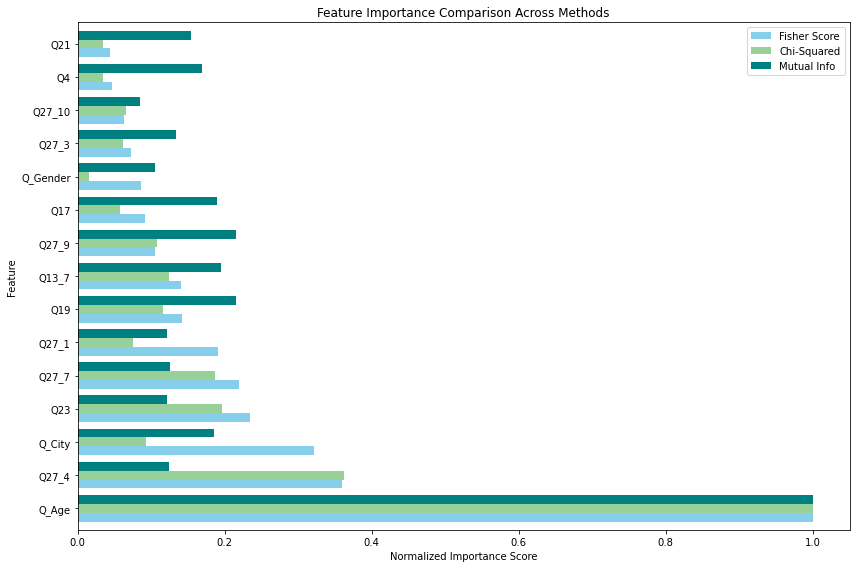


Consensus Features (Important in All Methods):
   Feature  Fisher_Score  Chi2_Score  IG_Score
0    Q_Age        0.0376     27.1673    0.0450
2   Q_City        0.0121      2.5358    0.0083
6      Q19        0.0053      3.1361    0.0097
7    Q13_7        0.0053      3.3607    0.0088
8    Q27_9        0.0039      2.9356    0.0097
9      Q17        0.0034      1.5472    0.0085
13      Q4        0.0017      0.9355    0.0076
14     Q21        0.0017      0.9174    0.0069
Selected features:
['Q_Age', 'Q_City', 'Q19', 'Q13_7', 'Q27_9', 'Q17', 'Q4', 'Q21']


In [10]:
#----------------------------------------------------------FEATURE SCALING -----------------------------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,  
    index=X_train.index       
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

#----------------------------------------------------------DOMAIN FEATURES-----------------------------------------------------

selected_features = ['Q4', 'Q7', 'Q13_5', 'Q16', 'Q17', 'Q20', 
                    'Q21', 'Q22', 'Q27_5', 'Q29']

X_train_domain = X_train_scaled[selected_features]
X_test_domain = X_test_scaled[selected_features]


#---------------------------------------------------------FORWARD SELECTION-----------------------------------------------------

model = LogisticRegression(max_iter = 10000, solver = 'saga', C = 0.1,class_weight = 'balanced')

sfs = SFS(model, k_features = 8, forward = True, floating = False, scoring = "accuracy", cv = 5)

sfs.fit(X_train_scaled, y_train)

accuracy = sfs.k_score_

selected_features = list(sfs.k_feature_names_)

X_train_FS = X_train_scaled[selected_features]
X_test_FS = X_test_scaled[selected_features]

print("Accuracy:", accuracy)
print("Selected Features:", sfs.k_feature_names_)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind = "line", y = "avg_score", ax = ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

#-----------------------------------------------------------FISHER SCORE-------------------------------------------------------

def manual_fisher_score(X, y):
    
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)
    scores = []
    
    for feature in X.T:  # Loop through each feature
        overall_mean = np.mean(feature)
        
        between_var = sum(
            [np.sum(y == cls) * (np.mean(feature[y == cls]) - overall_mean)**2 
            for cls in classes])
        
        within_var = sum([np.var(feature[y == cls]) * np.sum(y == cls) for cls in classes])
        
        fisher_score = between_var / (within_var + 1e-9)
        scores.append(fisher_score)
    
    return np.array(scores)

ranks = manual_fisher_score(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns, 
    'Fisher_Score': ranks
}).sort_values('Fisher_Score', ascending=False)

feature_importance['Percentile'] = (
    feature_importance['Fisher_Score'].rank(pct = True).round(2) * 100
)

print("Top 10 Features Fisher Scores:")
print(feature_importance.head(10))

#-----------------------------------------------------------CHI SQUARED-------------------------------------------------------

X_train_chi2 = X_train.copy()

discretizer = KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'quantile')
X_train_chi2['Q_Age'] = discretizer.fit_transform(X_train_chi2[['Q_Age']])

X_train_chi2 = X_train_chi2.astype(int)
chi_scores, p_values = chi2(X_train_chi2, y_train)

chi2_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Chi2_Score': chi_scores,
    'p_value': p_values
}).sort_values('Chi2_Score', ascending=False)

# Filter features on: p-value < 0.05 
significant_features = chi2_results[chi2_results['p_value'] < 0.4]
print("Significant Features by Chi-Squared Test (p < 0.05):")
print(significant_features)

#---------------------------------------------------------INFORMATION GAIN-----------------------------------------------------

def compute_stable_mi(X, y, n_runs=15, n_neighbors=5, random_state=42):
    
    mi_scores = np.zeros((n_runs, X.shape[1]))
    
    for i in range(n_runs):
        mi_scores[i] = mutual_info_classif(
            X, y,
            n_neighbors=n_neighbors,
            random_state=random_state + i
        )
    
    mean_scores = mi_scores.mean(axis = 0)
    valid_idx = mean_scores > 0.001
    return (
        pd.Series(mean_scores[valid_idx], index = X.columns[valid_idx]),
        mi_scores.std(axis=0)[valid_idx],
        valid_idx
    )

stable_mi, mi_std, valid_idx = compute_stable_mi(X_train, y_train)

ig_results = pd.DataFrame({
    'Feature': X_train.columns[valid_idx],
    'IG_Score': stable_mi.values,
    'IG_Variance': mi_std
}).sort_values('IG_Score', ascending=False)

ig_results['IG_Percentile'] = (ig_results['IG_Score'].rank(pct = True).round(3) * 100)

print("\nTop 20 Features by Stable Mutual Information:")
print(ig_results.head(20).to_string(float_format = "%.4f"))


#-----------------------------------------------------COMBINE RESULTS-----------------------------------------------------------

combined_results = (
    feature_importance
    .merge(chi2_results[['Feature', 'Chi2_Score', 'p_value']], on ='Feature', how = 'left')
    .merge(ig_results, on = 'Feature', how = 'left')
)

# Fill NA for features not present in all methods
combined_results.fillna({'IG_Score': 0, 'IG_Percentile': 0, 'IG_Variance': 0}, inplace = True)

plt.figure(figsize = (12, 8))
top_n = min(15, len(combined_results))
top_features = combined_results.nlargest(top_n, 'Fisher_Score').copy()

# Create normalized scores
top_features['Fisher_norm'] = top_features['Fisher_Score'] / top_features['Fisher_Score'].max()
top_features['Chi2_norm'] = top_features['Chi2_Score'] / top_features['Chi2_Score'].max()
top_features['IG_norm'] = top_features['IG_Score'] / top_features['IG_Score'].max()

# Plot with proper column names
plot_data = top_features.set_index('Feature')[['Fisher_norm', 'Chi2_norm', 'IG_norm']]
plot_data.plot(
    kind = 'barh',
    color = ['skyblue', '#98D09A', 'teal'],
    width = 0.8,
    figsize = (12,8)
)

plt.title('Feature Importance Comparison Across Methods')
plt.xlabel('Normalized Importance Score')
plt.ylabel('Feature')
plt.legend(['Fisher Score', 'Chi-Squared', 'Mutual Info'])
plt.tight_layout()
plt.show()

#--------------------------------------------------Combined top features of the three methods---------------------------------------------------

print("\nConsensus Features (Important in All Methods):")
consensus = combined_results[
    (combined_results['Percentile'] > 60) & 
    (combined_results['p_value'] < 0.4) &
    (combined_results['IG_Percentile'] > 60)
]
print(consensus[['Feature', 'Fisher_Score', 'Chi2_Score', 'IG_Score']].to_string(float_format = "%.4f"))

selected_features = consensus['Feature'].tolist()

#test_features(selected_features)               

print('Selected features:')
print(selected_features)

X_train_selected = X_train_scaled[selected_features].copy()
X_test_selected  = X_test_scaled[selected_features].copy()
selected_features = list(selected_features)



Detailed PCA Component Analysis:
   Component  Eigenvalue  Variance_Ratio  Cumulative_Variance  Variance_Percent  Cumulative_Percent
0        PC1      4.5344          0.1132               0.1132           11.3210             11.3210
1        PC2      2.4941          0.0623               0.1755            6.2272             17.5482
2        PC3      2.0365          0.0508               0.2263            5.0846             22.6327
3        PC4      1.7440          0.0435               0.2699            4.3544             26.9871
4        PC5      1.6418          0.0410               0.3109            4.0990             31.0861
5        PC6      1.4005          0.0350               0.3458            3.4966             34.5827
6        PC7      1.3289          0.0332               0.3790            3.3178             37.9005
7        PC8      1.2850          0.0321               0.4111            3.2083             41.1088
8        PC9      1.2249          0.0306               0.4417     

Q23      0.457891
Q28      0.394483
Q21      0.318913
Q27_3    0.258993
Q7       0.257022
Name: PLS4, dtype: float64

Top features for PLS5:
Q22       0.520863
Q27_7     0.367436
Q17       0.317553
Q_City    0.290677
Q27_5     0.260100
Name: PLS5, dtype: float64

Top features for PLS6:
Q23      0.412941
Q27_1    0.346965
Q19      0.312951
Q16      0.268919
Q14      0.245369
Name: PLS6, dtype: float64

Top features for PLS7:
Q_Age     0.456004
Q_City    0.265872
Q13_3     0.259191
Q13_10    0.246006
Q28       0.242588
Name: PLS7, dtype: float64

Top features for PLS8:
Q17         0.313606
Q_Gender    0.302637
Q13_7       0.286416
Q27_8       0.265438
Q13_3       0.254065
Name: PLS8, dtype: float64

Top features for PLS9:
Q27_7    0.302571
Q17      0.285624
Q15      0.270352
Q23      0.249275
Q20      0.237430
Name: PLS9, dtype: float64

Top features for PLS10:
Q4       0.387711
Q13_6    0.301362
Q27_5    0.270599
Q27_1    0.260058
Q_Age    0.227169
Name: PLS10, dtype: float64

Explained

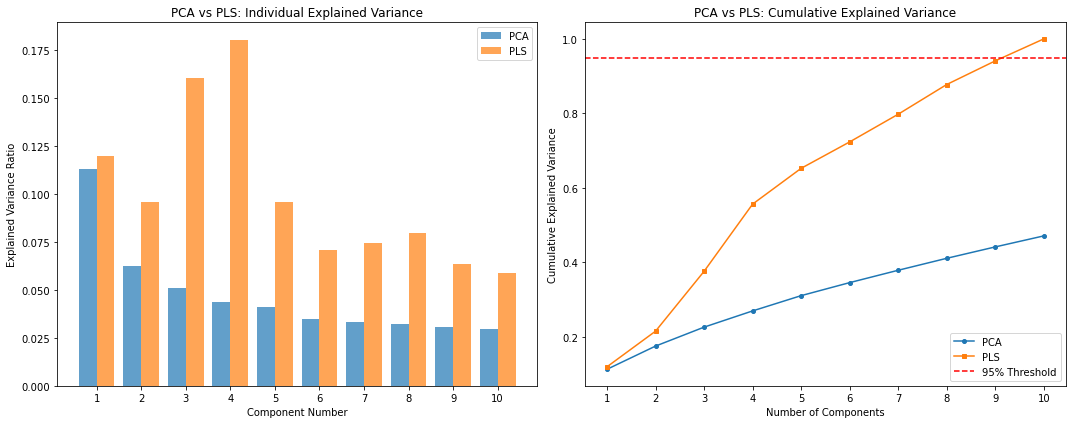

In [11]:
#-----------------------------------------------------------PCA------------------------------------------------------------------


pca = PCA()  
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

pca_variance_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Individual_Variance': explained_variance,
    'Cumulative_Variance': cumulative_variance
})

n_components = np.argmax(cumulative_variance >= 0.95) + 1

detailed_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Eigenvalue': pca.explained_variance_,
    'Variance_Ratio': pca.explained_variance_ratio_,
    'Cumulative_Variance': cumulative_variance,
    'Variance_Percent': pca.explained_variance_ratio_ * 100,
    'Cumulative_Percent': cumulative_variance * 100
})

print("\nDetailed PCA Component Analysis:")
print(detailed_variance.head(15).to_string(float_format=lambda x: f"{x:.4f}"))
    
pca_optimal = PCA(n_components=n_components)
X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_test_pca = pca_optimal.transform(X_test_scaled)

X_train_pca = pd.DataFrame(
    X_train_pca,
    columns = [f"PC{i+1}" for i in range(n_components)],
    index = X_train.index
)

X_test_pca = pd.DataFrame(
    X_test_pca,
    columns = [f"PC{i+1}" for i in range(n_components)],
    index = X_test.index
)

print(f"\nCreated PCA transformed datasets with {n_components} components")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

loadings = pd.DataFrame(
    pca_optimal.components_.T,
    columns = [f'PC{i+1}' for i in range(n_components)],
    index = X_train.columns
)

print("\nPCA Component Loadings (showing 5 features per component):")
for pc in loadings.columns:
    print(f"\nTop features for {pc}:")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))

#-----------------------------------------------------------PLS------------------------------------------------------------------

y_train_encoded = LabelEncoder().fit_transform(y_train)
n_components = 10

pls = PLSRegression(n_components=n_components)
X_train_pls = pls.fit_transform(X_train_scaled, y_train_encoded)[0]
X_test_pls = pls.transform(X_test_scaled)

X_train_pls = pd.DataFrame(X_train_pls, columns = [f'PLS{i+1}' for i in range(n_components)], index = X_train.index)
X_test_pls = pd.DataFrame(X_test_pls, columns = [f'PLS{i+1}' for i in range(n_components)], index = X_test.index)

pls_loadings = pd.DataFrame(
    pls.x_weights_,
    columns = [f'PLS{i+1}' for i in range(n_components)],
    index = X_train.columns
)

print("PLS Component Loadings (X-weights):")
print(pls_loadings)

for component in pls_loadings.columns:
    print(f"\nTop features for {component}:")
    print(pls_loadings[component].abs().sort_values(ascending=False).head(5))

pls_explained_variance = pls.x_scores_.var(axis=0) / pls.x_scores_.var(axis=0).sum()
print("\nExplained Variance per PLS Component (X-space):")
print(pd.Series(pls_explained_variance, index = [f'PLS{i+1}' for i in range(n_components)]))

print("\nPLS Model Coefficients (for original features):")
print(pd.Series(pls.coef_.flatten(), index=X_train.columns))

pls_variance_df = pd.DataFrame({
    'Component': [f'PLS{i+1}' for i in range(len(pls_explained_variance))],
    'Variance_Ratio': pls_explained_variance,
    'Cumulative_PLS': np.cumsum(pls_explained_variance)
})

#-----------------------------------------------------------PLS and PCA COMPARISON------------------------------------------------------------------


print("\n=== PCA vs PLS Explained Variance Comparison ===")
comparison_df = pd.DataFrame({
    'Component_Num': range(1, min(len(explained_variance), len(pls_explained_variance))+1),
    'PCA_Component': [f'PC{i}' for i in range(1, min(len(explained_variance), len(pls_explained_variance))+1)],
    'PCA_Variance': explained_variance[:len(pls_explained_variance)],
    'PCA_Cumulative': cumulative_variance[:len(pls_explained_variance)],
    'PLS_Component': [f'PLS{i}' for i in range(1, min(len(explained_variance), len(pls_explained_variance))+1)],
    'PLS_Variance': pls_explained_variance,
    'PLS_Cumulative': np.cumsum(pls_explained_variance)
})

print(comparison_df.head(10).to_string(float_format=lambda x: f"{x:.4f}"))

plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.bar([i-0.2 for i in range(1, 11)], explained_variance[:10], width = 0.4, label = 'PCA', alpha = 0.7)
plt.bar([i+0.2 for i in range(1, 11)], pls_explained_variance[:10], width = 0.4, label = 'PLS', alpha = 0.7)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA vs PLS: Individual Explained Variance')
plt.legend()
plt.xticks(range(1, 11))

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), cumulative_variance[:10], 'o-', label = 'PCA', markersize = 4)
plt.plot(range(1, 11), np.cumsum(pls_explained_variance)[:10], 's-', label = 'PLS', markersize = 4)
plt.axhline(y=0.95, color = 'r', linestyle='--', label = '95% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA vs PLS: Cumulative Explained Variance')
plt.legend()
plt.xticks(range(1, 11))
plt.tight_layout()
plt.show()

RUNNING LOGISTIC REGRESSION MODELS

--- Logistic Regression on Original Dataset ---
Logistic Regression Results:
Accuracy: 0.6471
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.62        42
         1.0       0.64      0.70      0.67        43

    accuracy                           0.65        85
   macro avg       0.65      0.65      0.65        85
weighted avg       0.65      0.65      0.65        85

[[25 17]
 [13 30]]


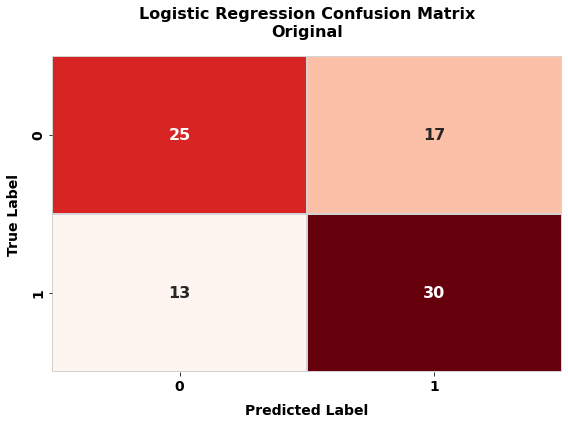

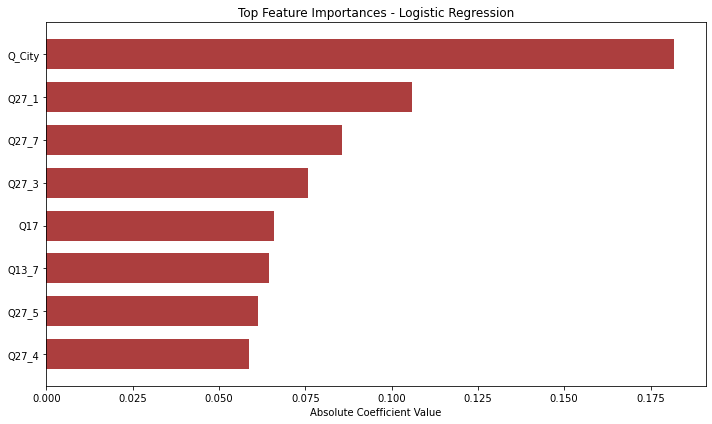


--- Logistic Regression on Scaled Dataset ---
Logistic Regression Results:
Accuracy: 0.6588
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64        42
         1.0       0.65      0.70      0.67        43

    accuracy                           0.66        85
   macro avg       0.66      0.66      0.66        85
weighted avg       0.66      0.66      0.66        85

[[26 16]
 [13 30]]


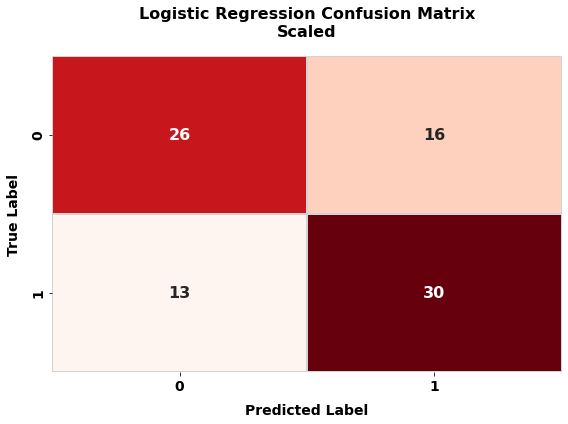

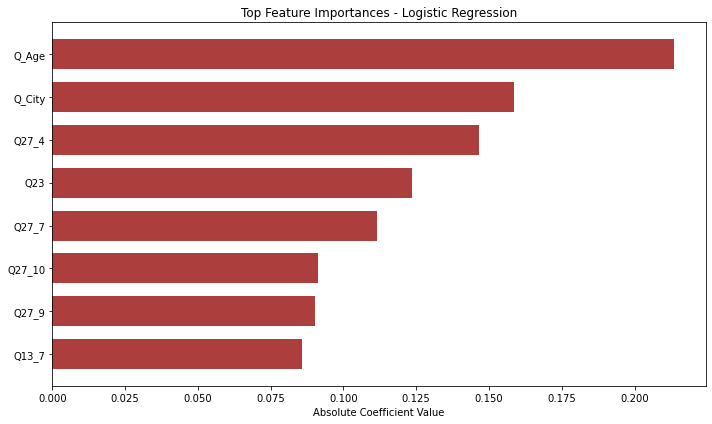


--- Logistic Regression on Selected Dataset ---
Logistic Regression Results:
Accuracy: 0.6824
              precision    recall  f1-score   support

         0.0       0.70      0.62      0.66        42
         1.0       0.67      0.74      0.70        43

    accuracy                           0.68        85
   macro avg       0.68      0.68      0.68        85
weighted avg       0.68      0.68      0.68        85

[[26 16]
 [11 32]]


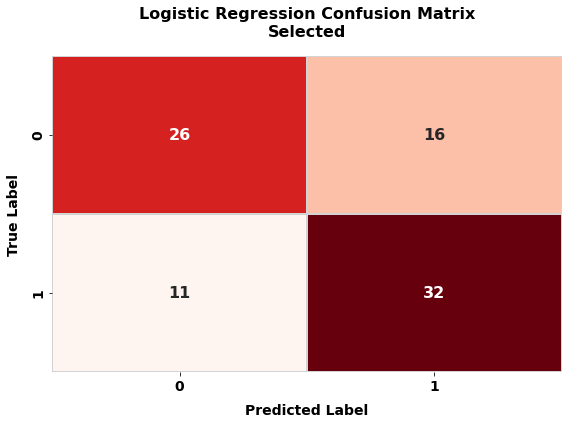

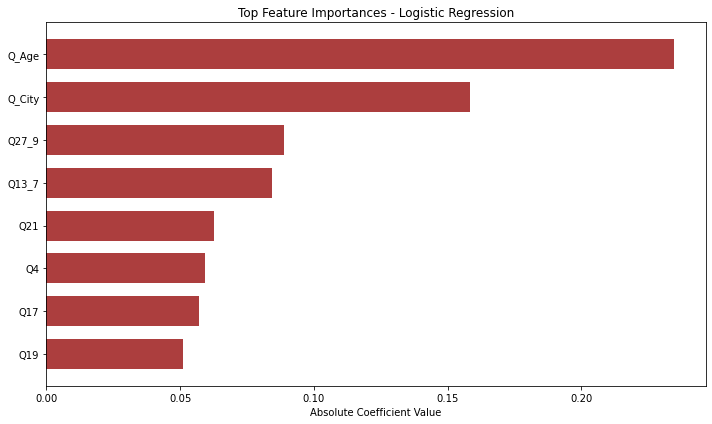


--- Logistic Regression on Forward selection Dataset ---
Logistic Regression Results:
Accuracy: 0.5765
              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54        42
         1.0       0.57      0.65      0.61        43

    accuracy                           0.58        85
   macro avg       0.58      0.58      0.57        85
weighted avg       0.58      0.58      0.57        85

[[21 21]
 [15 28]]


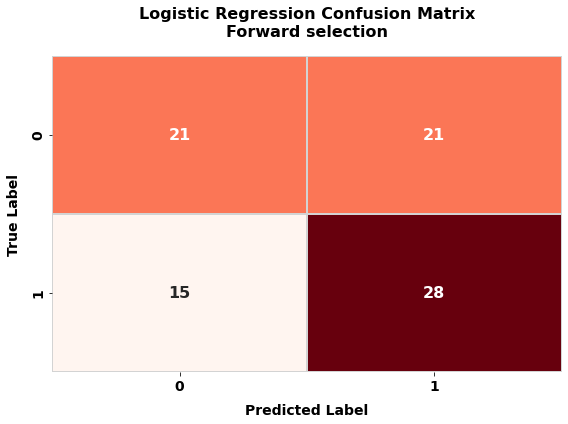

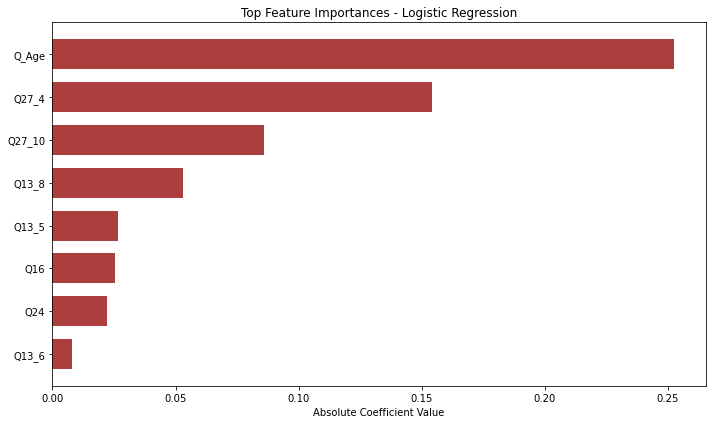


--- Logistic Regression on Domain Dataset ---
Logistic Regression Results:
Accuracy: 0.5647
              precision    recall  f1-score   support

         0.0       0.57      0.50      0.53        42
         1.0       0.56      0.63      0.59        43

    accuracy                           0.56        85
   macro avg       0.57      0.56      0.56        85
weighted avg       0.57      0.56      0.56        85

[[21 21]
 [16 27]]


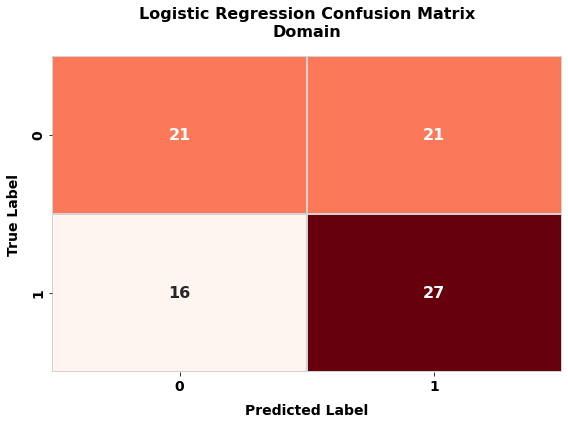

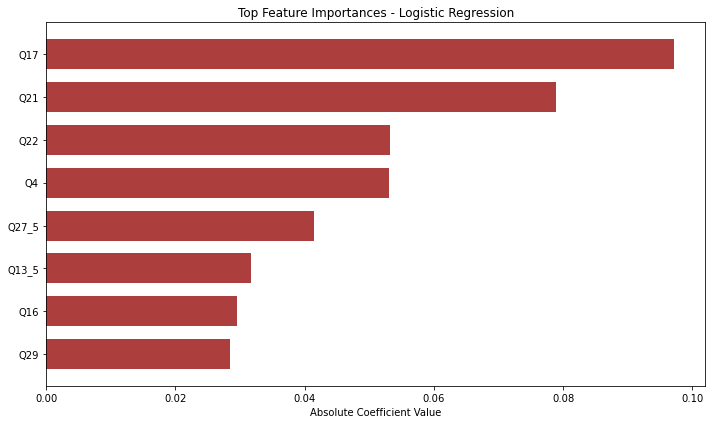


--- Logistic Regression on PCA Dataset ---
Logistic Regression Results:
Accuracy: 0.6235
              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61        42
         1.0       0.62      0.65      0.64        43

    accuracy                           0.62        85
   macro avg       0.62      0.62      0.62        85
weighted avg       0.62      0.62      0.62        85

[[25 17]
 [15 28]]


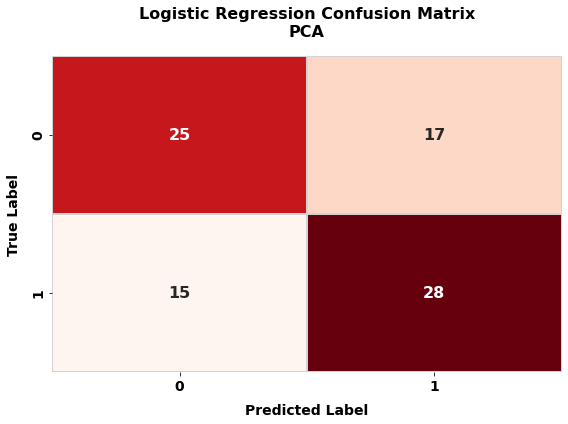

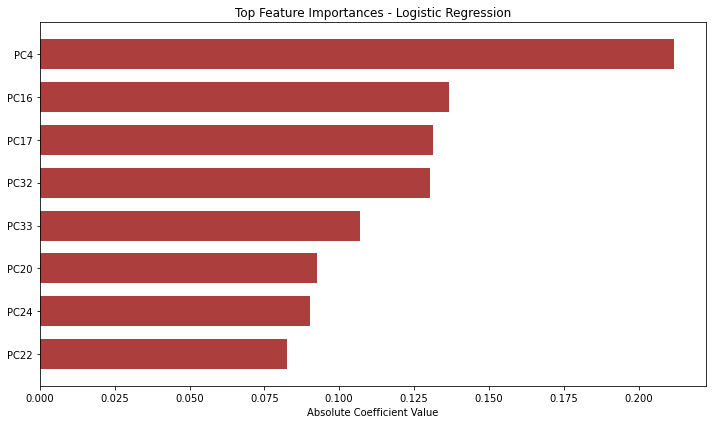


--- Logistic Regression on PLS Dataset ---
Logistic Regression Results:
Accuracy: 0.6588
              precision    recall  f1-score   support

         0.0       0.68      0.60      0.63        42
         1.0       0.65      0.72      0.68        43

    accuracy                           0.66        85
   macro avg       0.66      0.66      0.66        85
weighted avg       0.66      0.66      0.66        85

[[25 17]
 [12 31]]


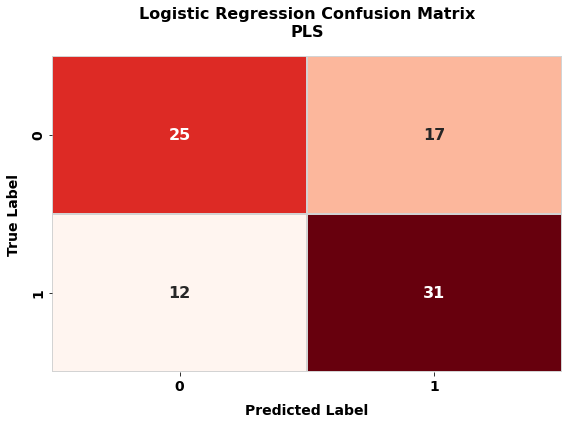

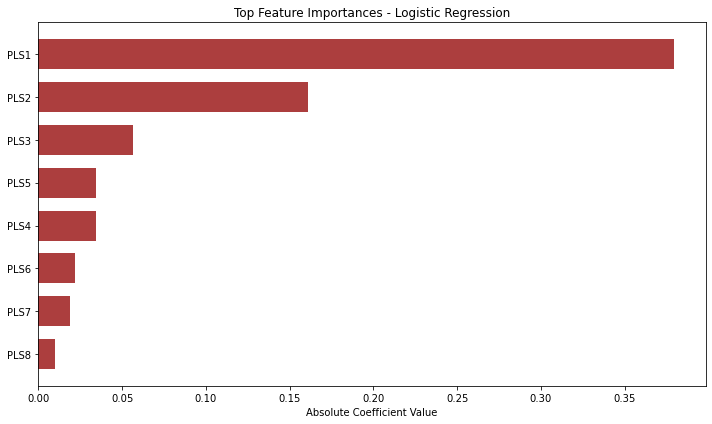

RUNNING SVM MODELS

--- SVM on Original Dataset ---
SVM Results:
Accuracy: 0.6118
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        42
         1.0       0.62      0.58      0.60        43

    accuracy                           0.61        85
   macro avg       0.61      0.61      0.61        85
weighted avg       0.61      0.61      0.61        85

[[27 15]
 [18 25]]


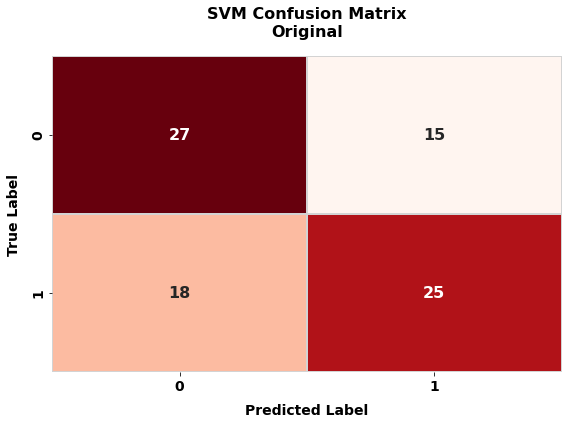

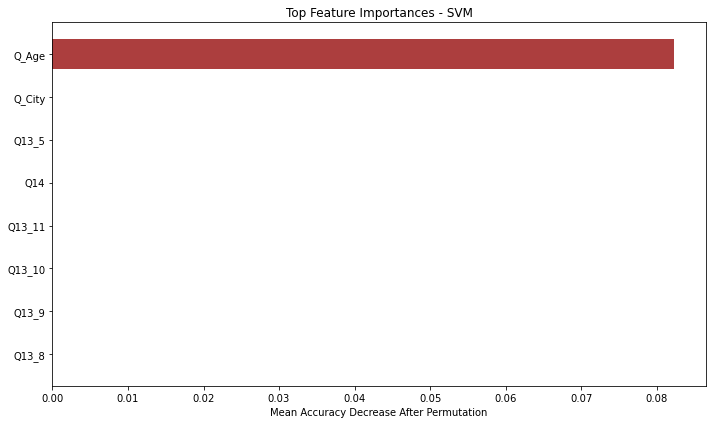


--- SVM on Scaled Dataset ---
SVM Results:
Accuracy: 0.6235
              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59        42
         1.0       0.61      0.70      0.65        43

    accuracy                           0.62        85
   macro avg       0.63      0.62      0.62        85
weighted avg       0.63      0.62      0.62        85

[[23 19]
 [13 30]]


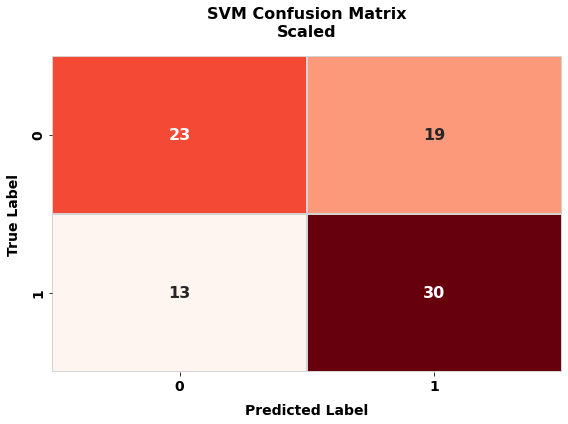

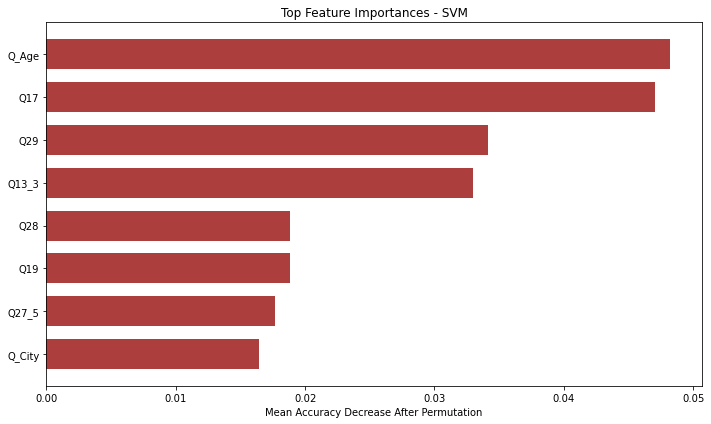


--- SVM on Selected Dataset ---
SVM Results:
Accuracy: 0.6471
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.62        42
         1.0       0.64      0.70      0.67        43

    accuracy                           0.65        85
   macro avg       0.65      0.65      0.65        85
weighted avg       0.65      0.65      0.65        85

[[25 17]
 [13 30]]


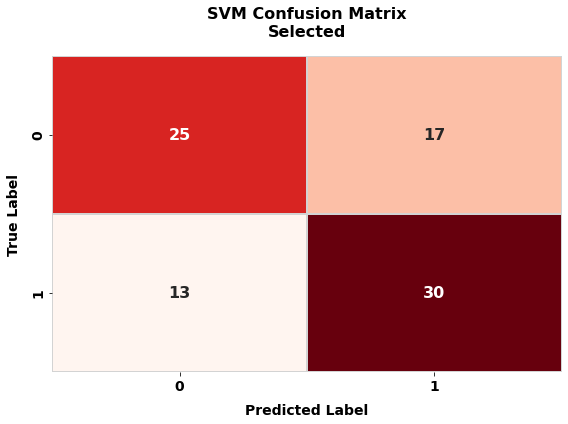

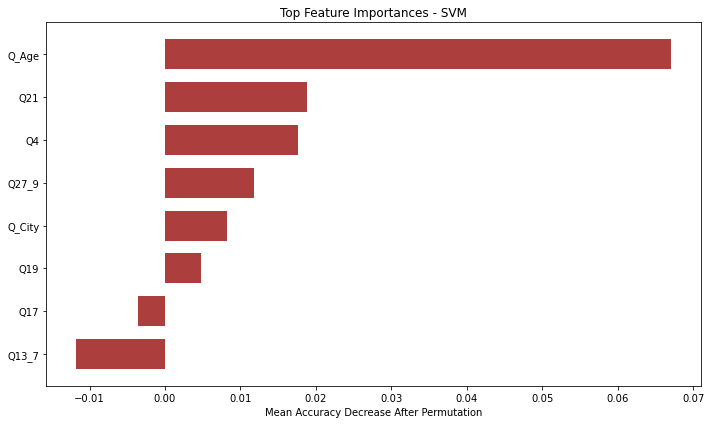


--- SVM on Forward selection Dataset ---
SVM Results:
Accuracy: 0.6000
              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60        42
         1.0       0.60      0.60      0.60        43

    accuracy                           0.60        85
   macro avg       0.60      0.60      0.60        85
weighted avg       0.60      0.60      0.60        85

[[25 17]
 [17 26]]


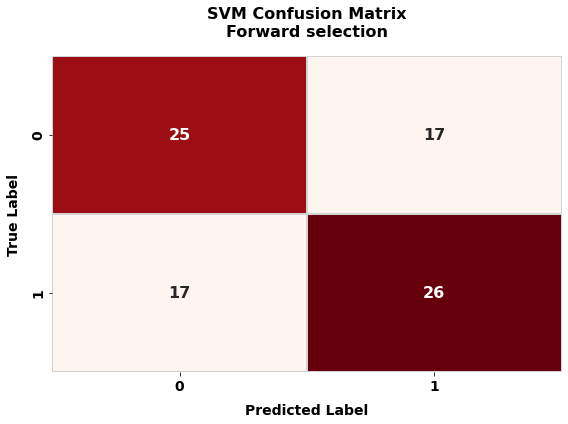

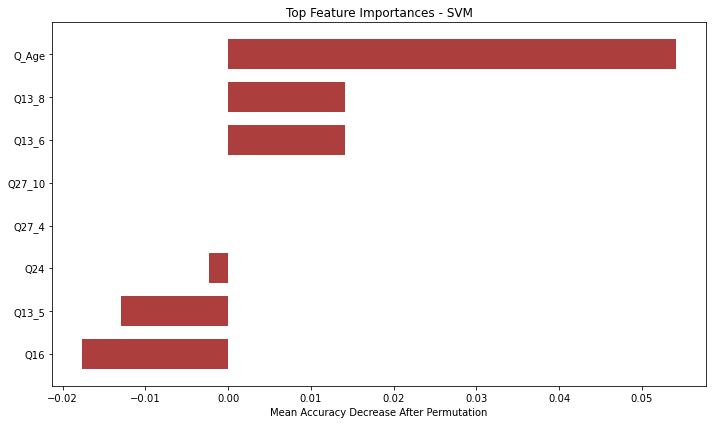


--- SVM on Domain Dataset ---
SVM Results:
Accuracy: 0.5412
              precision    recall  f1-score   support

         0.0       0.53      0.55      0.54        42
         1.0       0.55      0.53      0.54        43

    accuracy                           0.54        85
   macro avg       0.54      0.54      0.54        85
weighted avg       0.54      0.54      0.54        85

[[23 19]
 [20 23]]


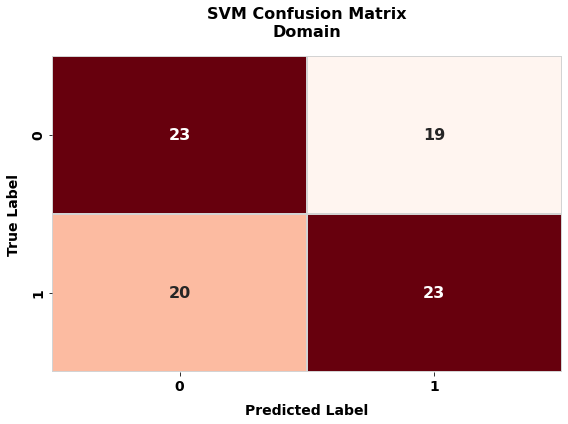

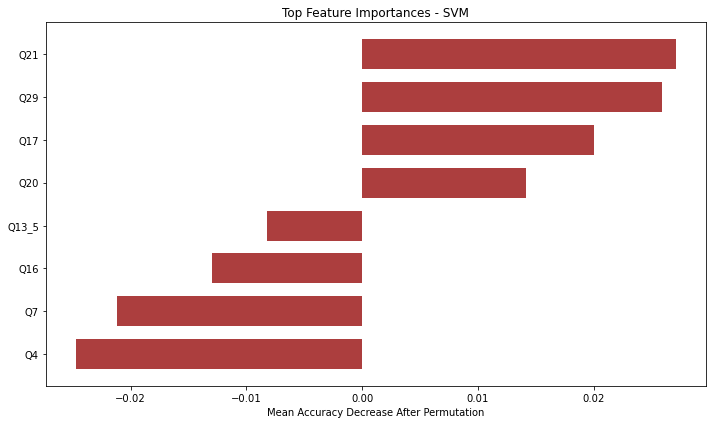


--- SVM on PCA Dataset ---
SVM Results:
Accuracy: 0.6000
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.57        42
         1.0       0.60      0.65      0.62        43

    accuracy                           0.60        85
   macro avg       0.60      0.60      0.60        85
weighted avg       0.60      0.60      0.60        85

[[23 19]
 [15 28]]


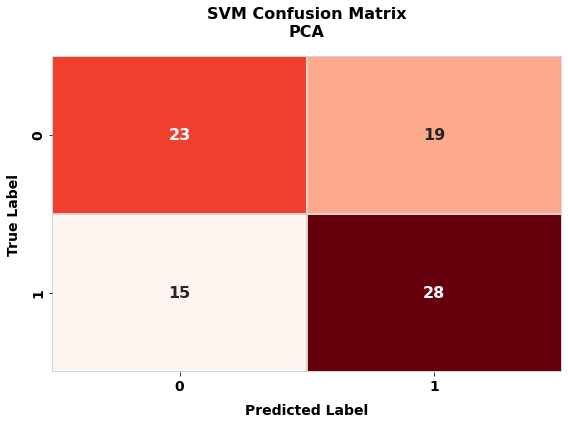

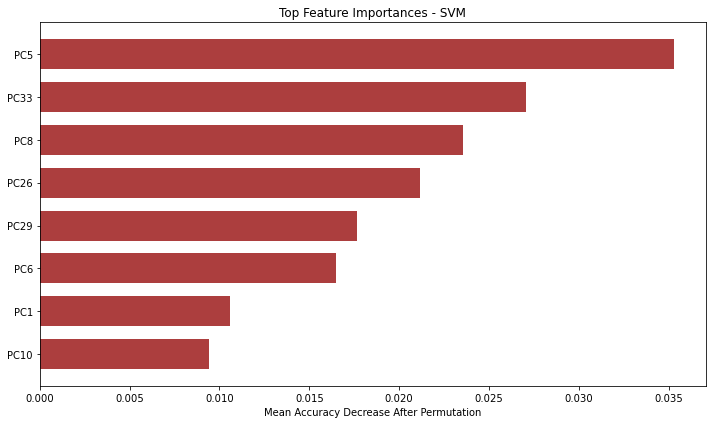


--- SVM on PLS Dataset ---
SVM Results:
Accuracy: 0.7059
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69        42
         1.0       0.70      0.74      0.72        43

    accuracy                           0.71        85
   macro avg       0.71      0.71      0.71        85
weighted avg       0.71      0.71      0.71        85

[[28 14]
 [11 32]]


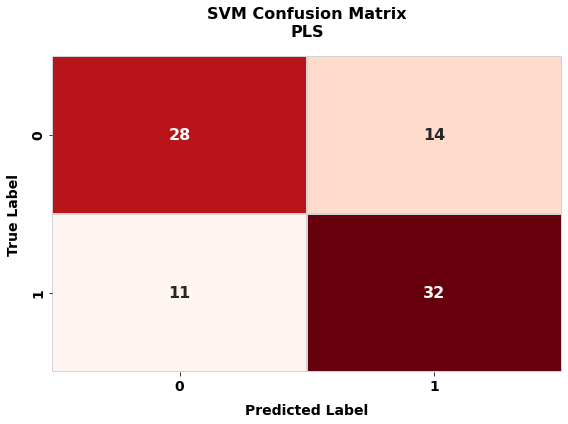

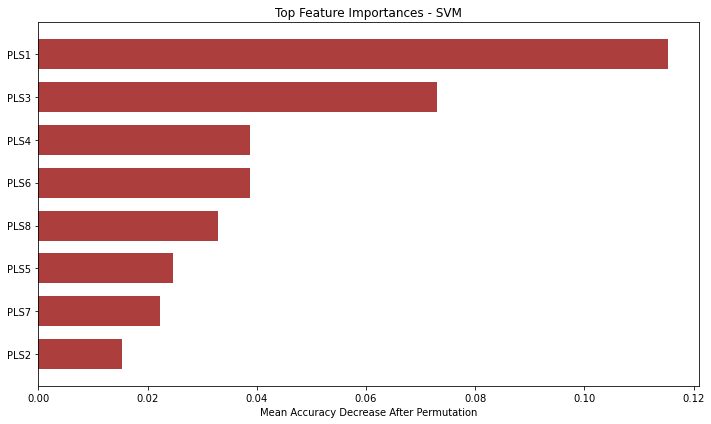

RUNNING RANDOM FOREST MODELS

--- Random Forest on Original Dataset ---
Random Forest Results:
Accuracy: 0.6353
              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64        42
         1.0       0.65      0.60      0.63        43

    accuracy                           0.64        85
   macro avg       0.64      0.64      0.64        85
weighted avg       0.64      0.64      0.63        85

[[28 14]
 [17 26]]


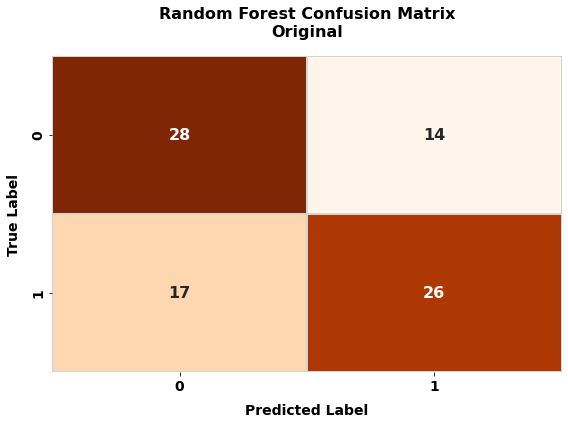

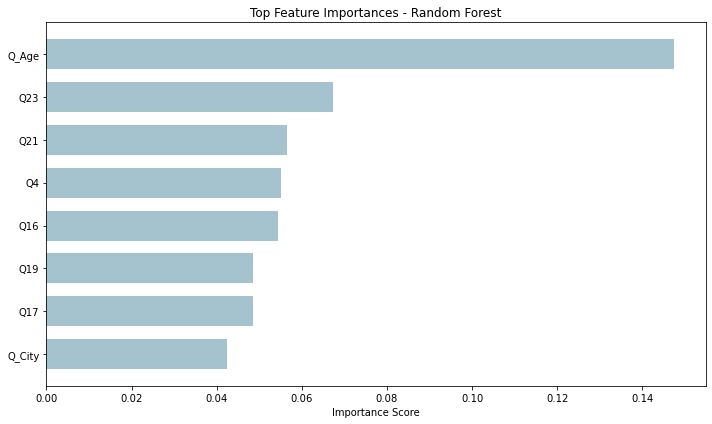


--- Random Forest on Scaled Dataset ---
Random Forest Results:
Accuracy: 0.6235
              precision    recall  f1-score   support

         0.0       0.61      0.67      0.64        42
         1.0       0.64      0.58      0.61        43

    accuracy                           0.62        85
   macro avg       0.62      0.62      0.62        85
weighted avg       0.63      0.62      0.62        85

[[28 14]
 [18 25]]


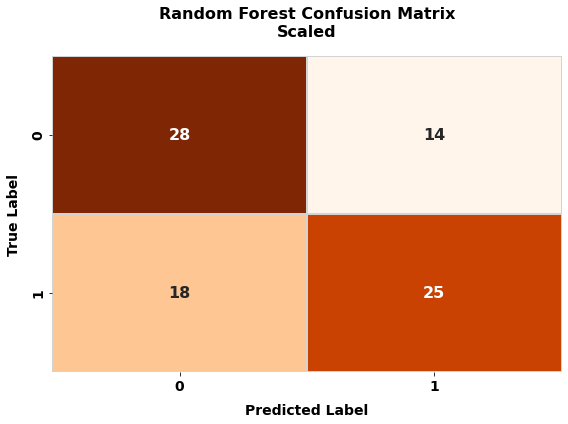

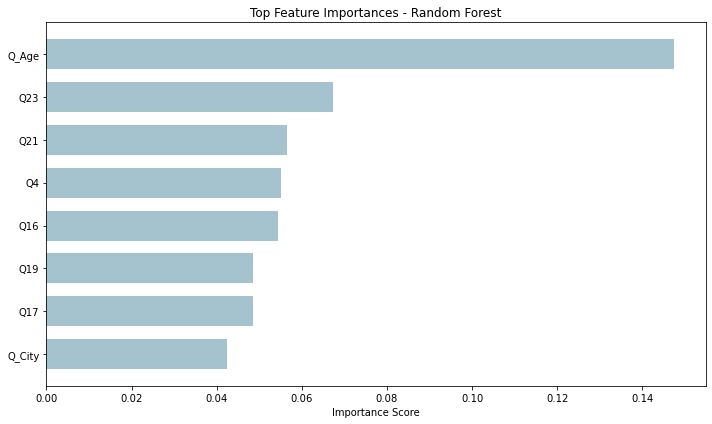


--- Random Forest on Selected Dataset ---
Random Forest Results:
Accuracy: 0.5765
              precision    recall  f1-score   support

         0.0       0.57      0.55      0.56        42
         1.0       0.58      0.60      0.59        43

    accuracy                           0.58        85
   macro avg       0.58      0.58      0.58        85
weighted avg       0.58      0.58      0.58        85

[[23 19]
 [17 26]]


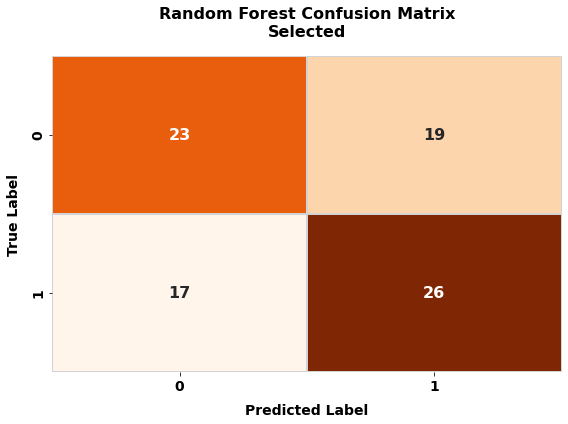

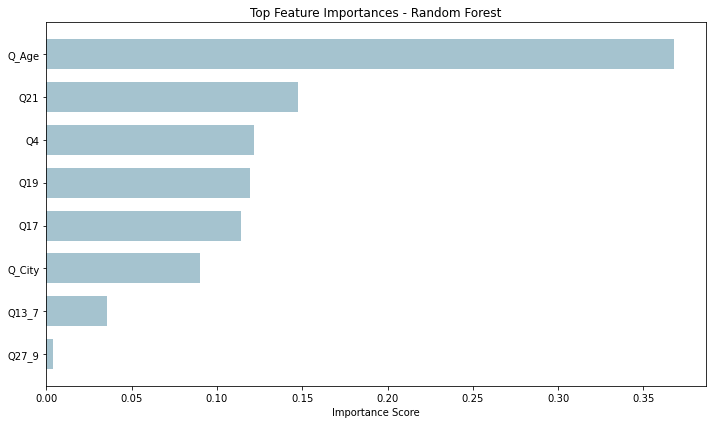


--- Random Forest on Forward selection Dataset ---
Random Forest Results:
Accuracy: 0.5529
              precision    recall  f1-score   support

         0.0       0.54      0.64      0.59        42
         1.0       0.57      0.47      0.51        43

    accuracy                           0.55        85
   macro avg       0.56      0.55      0.55        85
weighted avg       0.56      0.55      0.55        85

[[27 15]
 [23 20]]


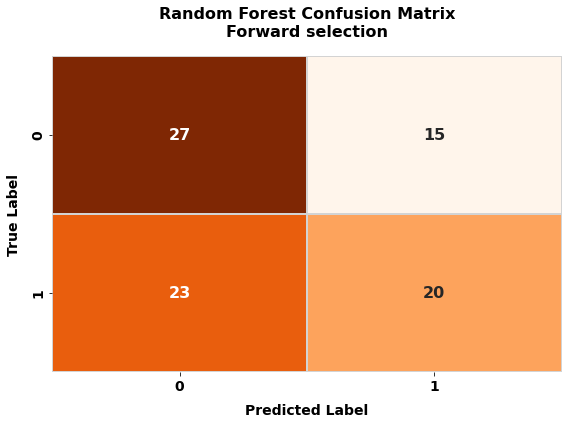

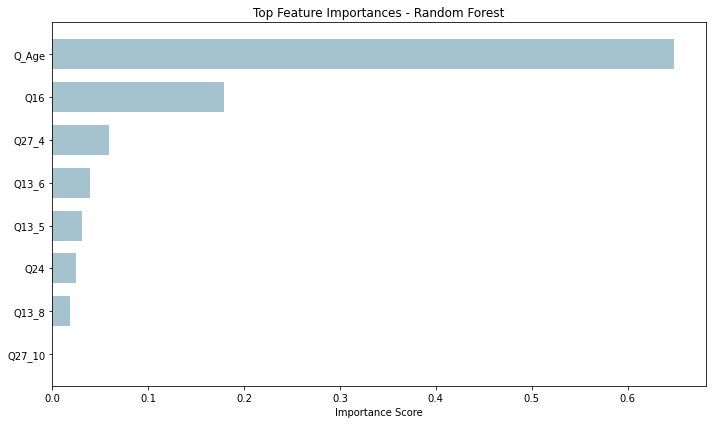


--- Random Forest on Domain Dataset ---
Random Forest Results:
Accuracy: 0.4941
              precision    recall  f1-score   support

         0.0       0.49      0.60      0.54        42
         1.0       0.50      0.40      0.44        43

    accuracy                           0.49        85
   macro avg       0.50      0.50      0.49        85
weighted avg       0.50      0.49      0.49        85

[[25 17]
 [26 17]]


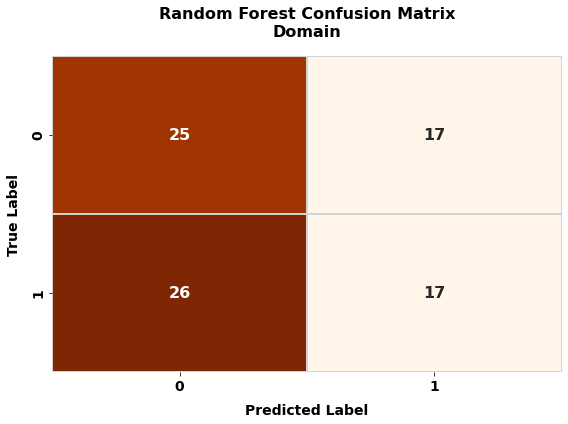

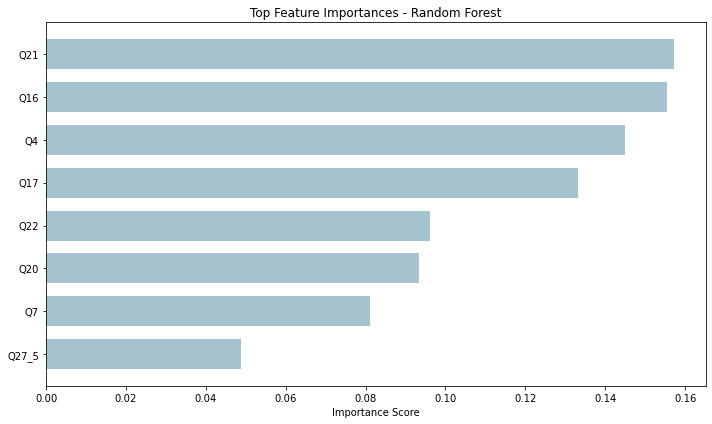


--- Random Forest on PCA Dataset ---
Random Forest Results:
Accuracy: 0.5647
              precision    recall  f1-score   support

         0.0       0.55      0.62      0.58        42
         1.0       0.58      0.51      0.54        43

    accuracy                           0.56        85
   macro avg       0.57      0.57      0.56        85
weighted avg       0.57      0.56      0.56        85

[[26 16]
 [21 22]]


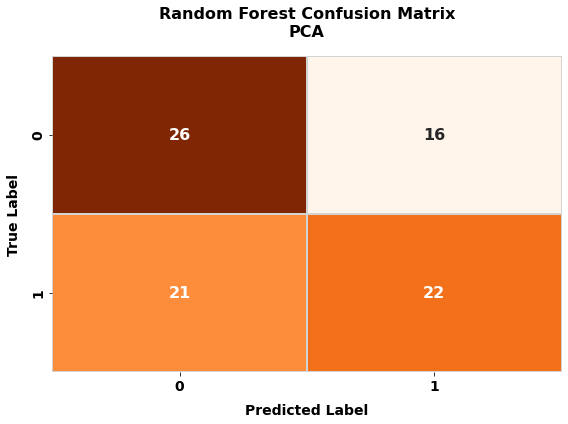

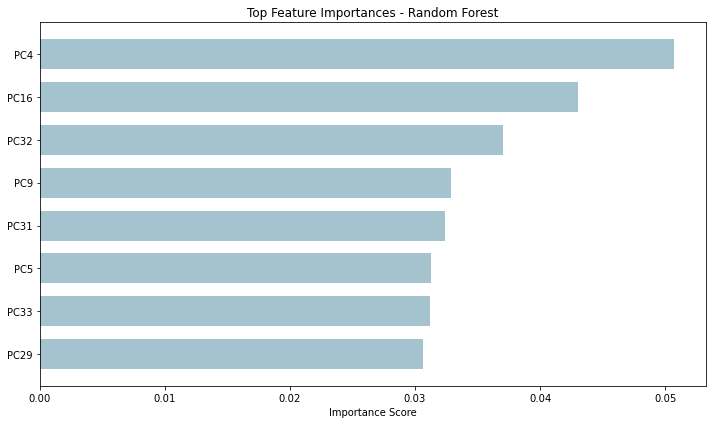


--- Random Forest on PLS Dataset ---
Random Forest Results:
Accuracy: 0.6824
              precision    recall  f1-score   support

         0.0       0.68      0.67      0.67        42
         1.0       0.68      0.70      0.69        43

    accuracy                           0.68        85
   macro avg       0.68      0.68      0.68        85
weighted avg       0.68      0.68      0.68        85

[[28 14]
 [13 30]]


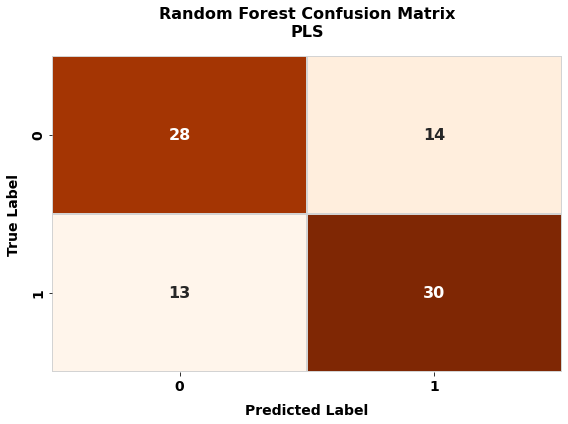

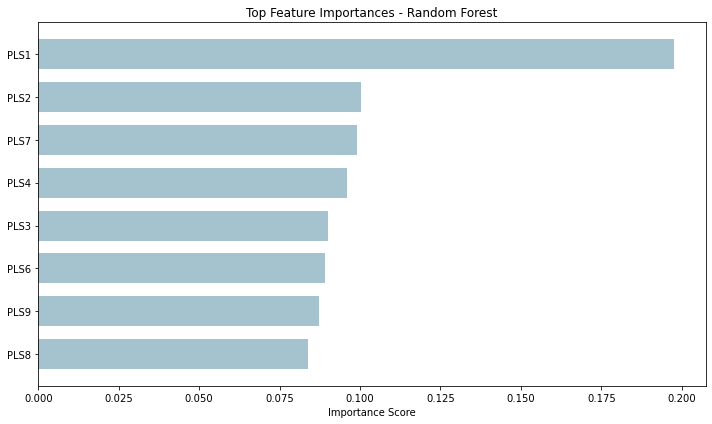

RUNNING XGBOOST MODELS

--- XGBoost on Original Dataset ---


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.6235
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        42
         1.0       0.66      0.53      0.59        43

    accuracy                           0.62        85
   macro avg       0.63      0.62      0.62        85
weighted avg       0.63      0.62      0.62        85

[[30 12]
 [20 23]]


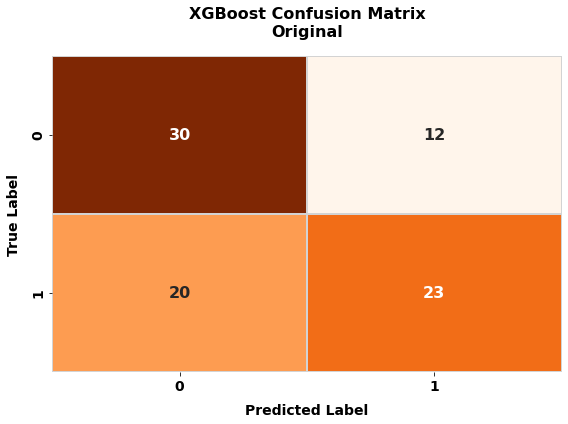

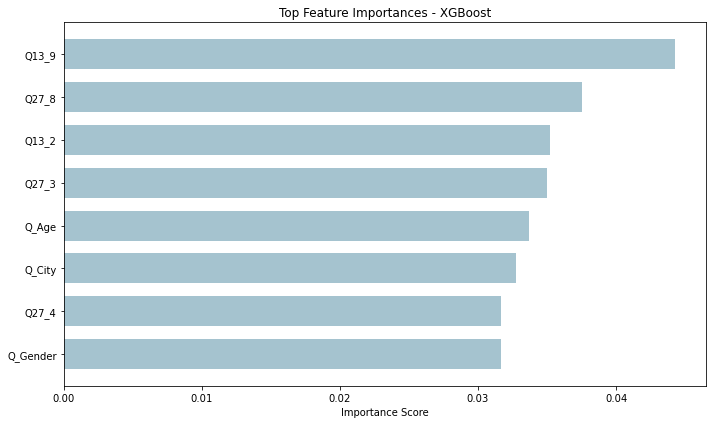


--- XGBoost on Scaled Dataset ---
XGBoost Results:
Accuracy: 0.6235


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        42
         1.0       0.66      0.53      0.59        43

    accuracy                           0.62        85
   macro avg       0.63      0.62      0.62        85
weighted avg       0.63      0.62      0.62        85

[[30 12]
 [20 23]]


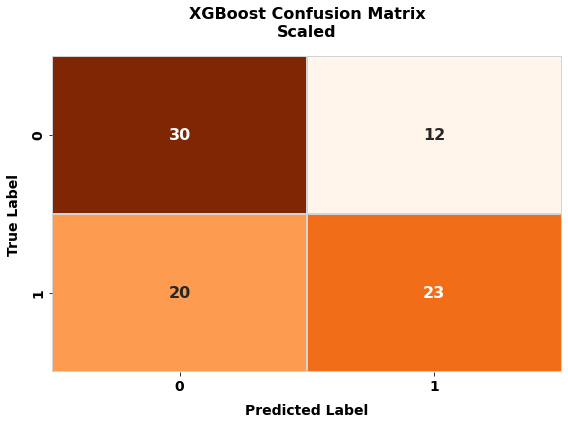

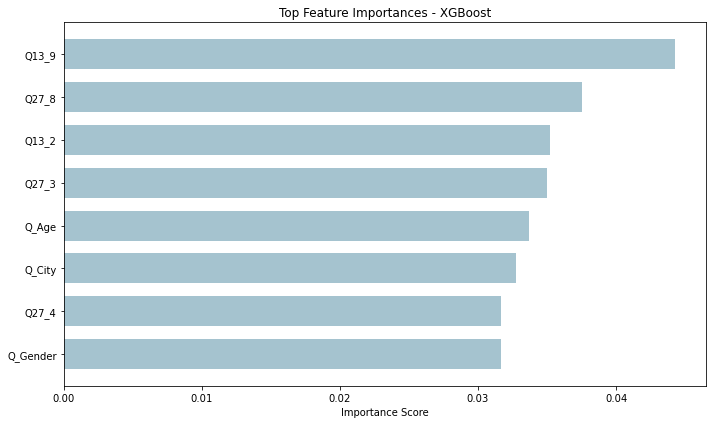


--- XGBoost on Selected Dataset ---
XGBoost Results:
Accuracy: 0.5765
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59        42
         1.0       0.59      0.53      0.56        43

    accuracy                           0.58        85
   macro avg       0.58      0.58      0.58        85
weighted avg       0.58      0.58      0.58        85

[[26 16]
 [20 23]]


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


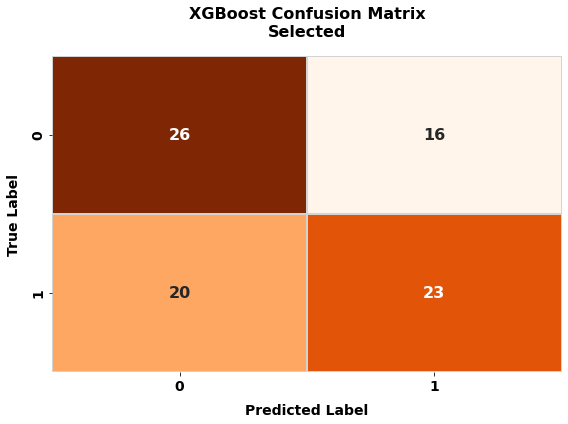

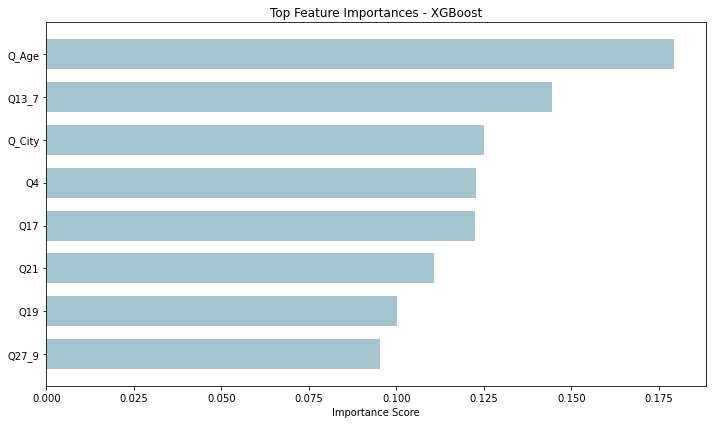


--- XGBoost on Forward selection Dataset ---
XGBoost Results:
Accuracy: 0.5765
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59        42
         1.0       0.59      0.53      0.56        43

    accuracy                           0.58        85
   macro avg       0.58      0.58      0.58        85
weighted avg       0.58      0.58      0.58        85

[[26 16]
 [20 23]]


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


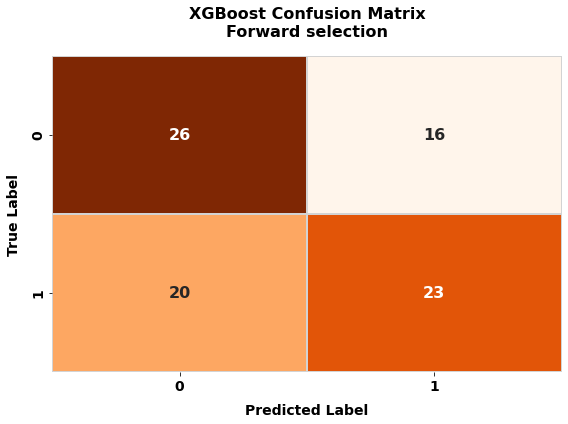

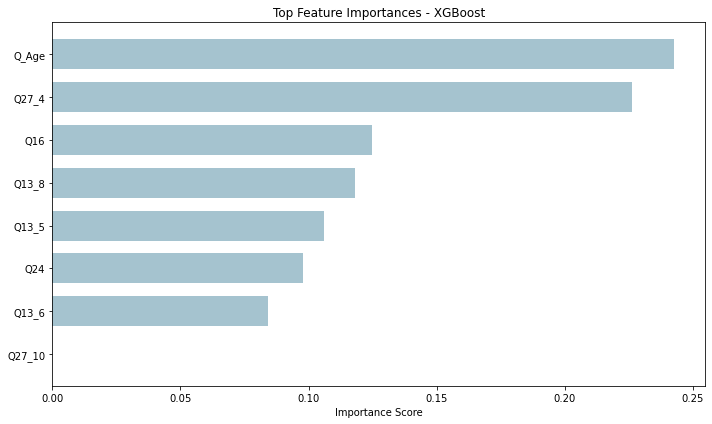


--- XGBoost on Domain Dataset ---
XGBoost Results:
Accuracy: 0.5294
              precision    recall  f1-score   support

         0.0       0.52      0.71      0.60        42
         1.0       0.56      0.35      0.43        43

    accuracy                           0.53        85
   macro avg       0.54      0.53      0.51        85
weighted avg       0.54      0.53      0.51        85

[[30 12]
 [28 15]]


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


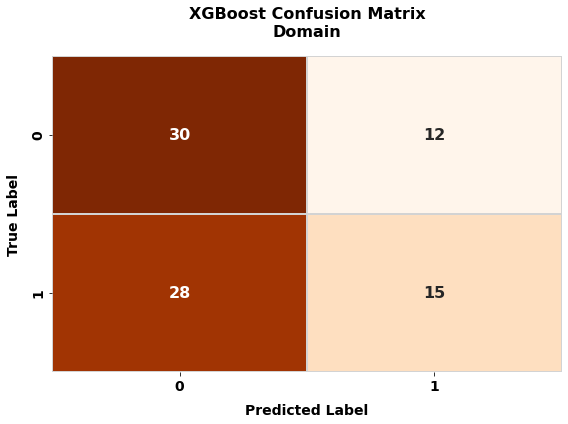

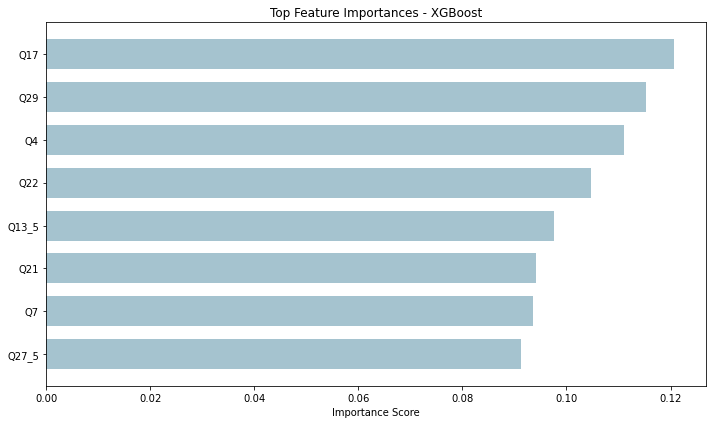


--- XGBoost on PCA Dataset ---


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.5529
              precision    recall  f1-score   support

         0.0       0.54      0.60      0.57        42
         1.0       0.56      0.51      0.54        43

    accuracy                           0.55        85
   macro avg       0.55      0.55      0.55        85
weighted avg       0.55      0.55      0.55        85

[[25 17]
 [21 22]]


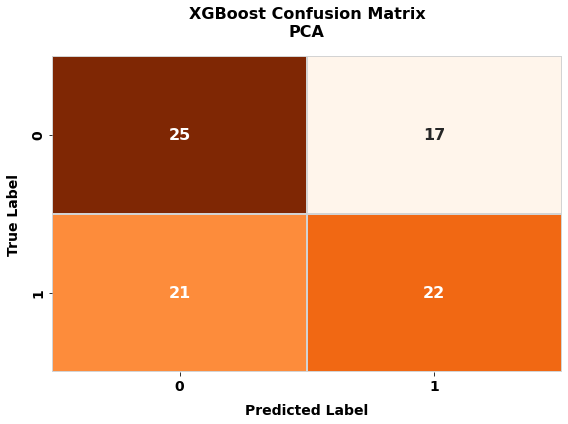

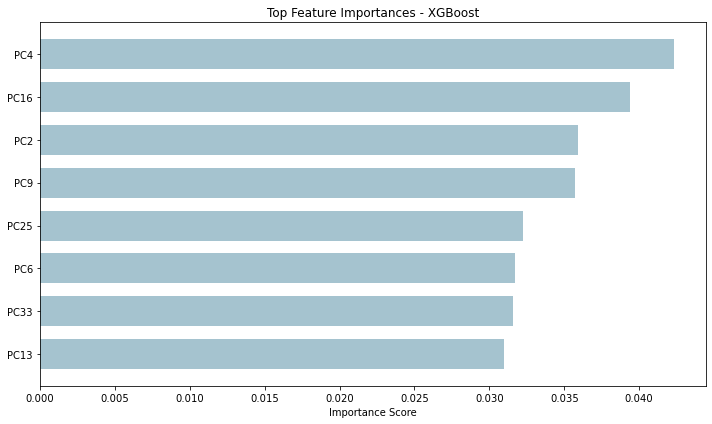


--- XGBoost on PLS Dataset ---
XGBoost Results:
Accuracy: 0.6706
              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67        42
         1.0       0.68      0.65      0.67        43

    accuracy                           0.67        85
   macro avg       0.67      0.67      0.67        85
weighted avg       0.67      0.67      0.67        85

[[29 13]
 [15 28]]


C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


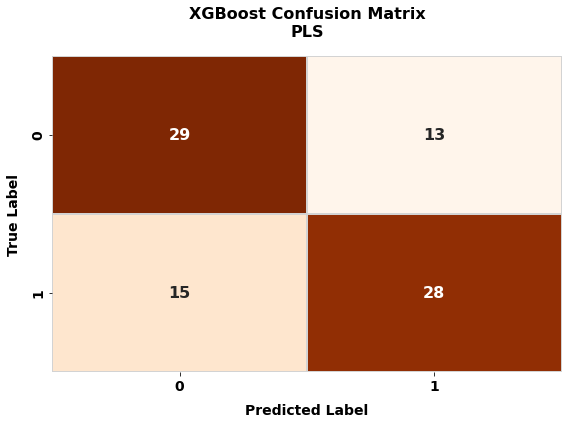

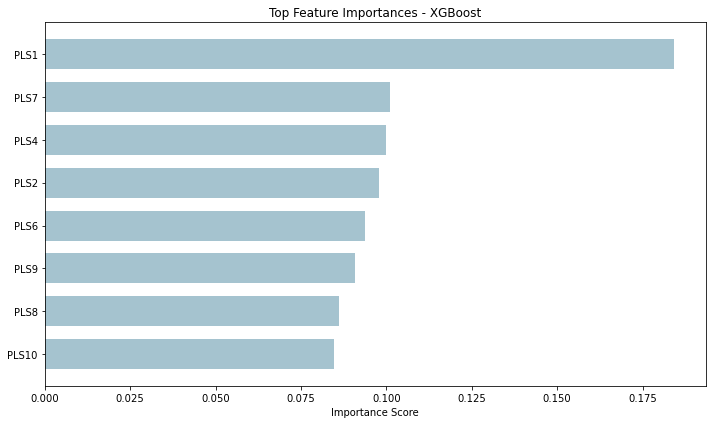

RUNNING LIGHTGBM MODELS

--- LightGBM on Original Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

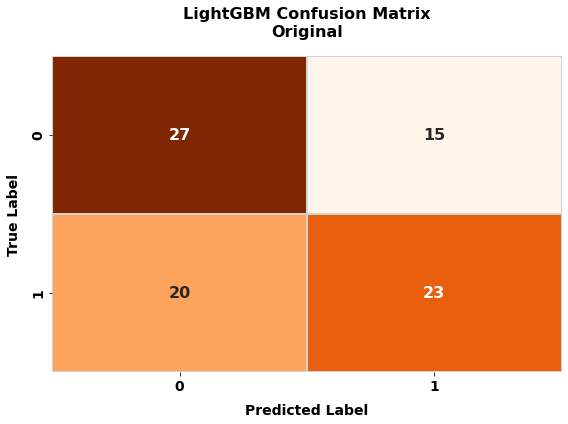

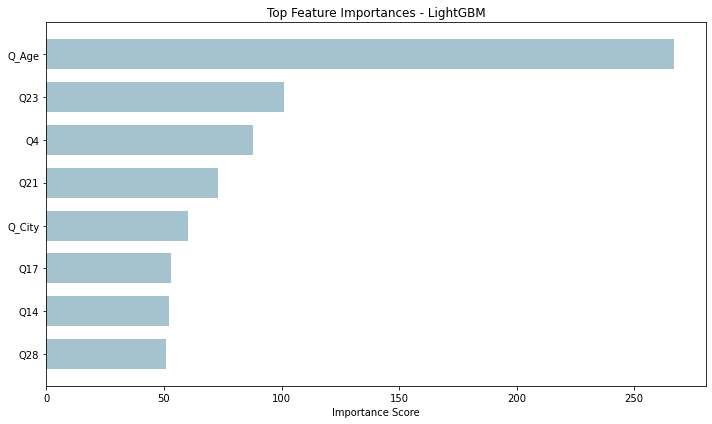


--- LightGBM on Scaled Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 221
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

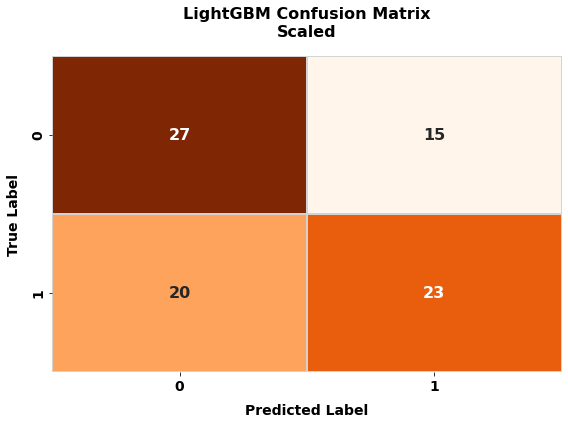

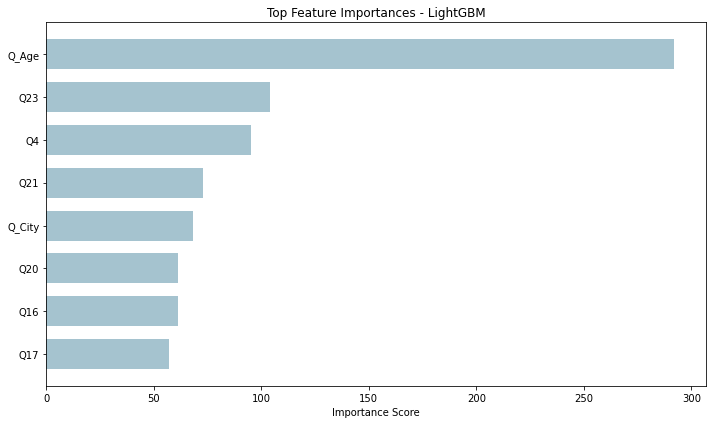


--- LightGBM on Selected Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

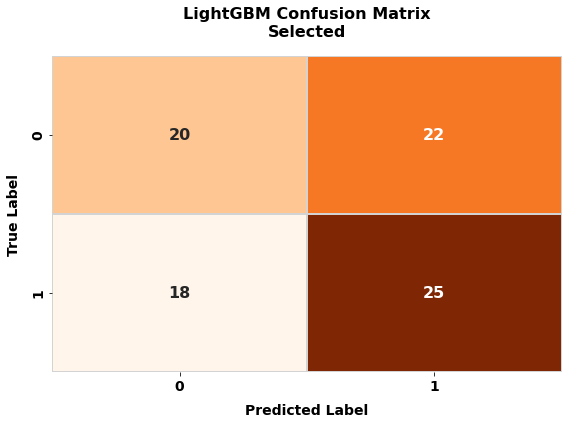

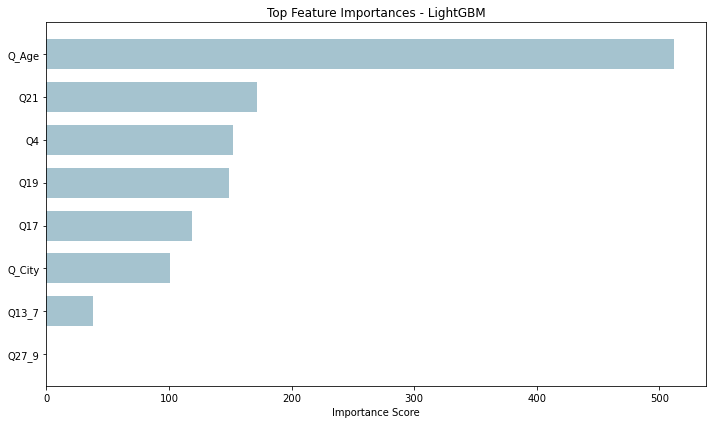


--- LightGBM on Forward selection Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

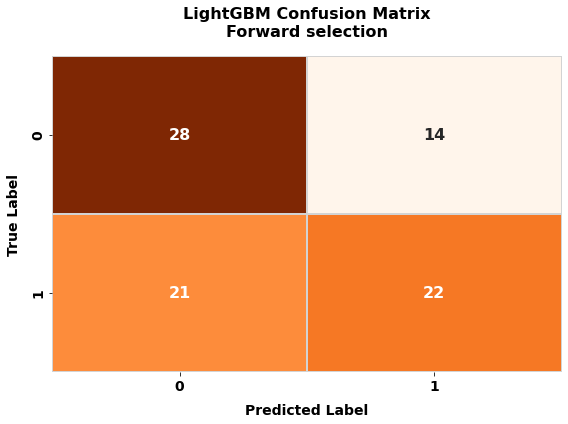

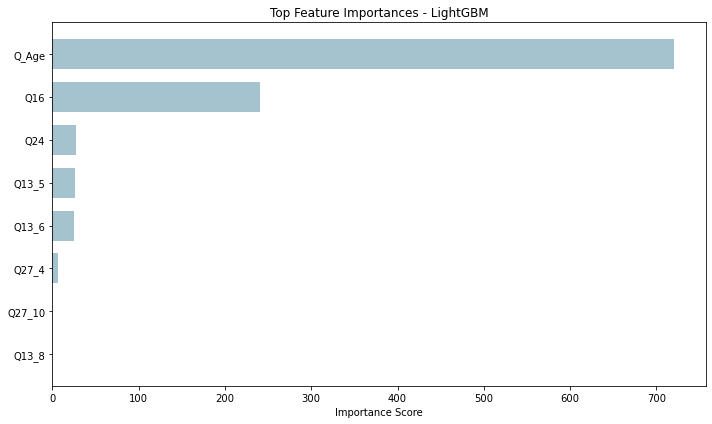


--- LightGBM on Domain Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

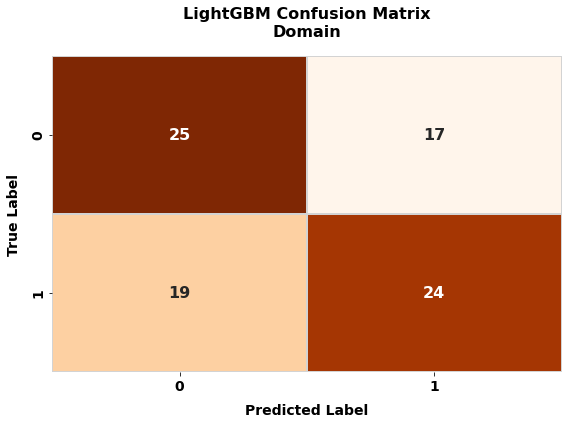

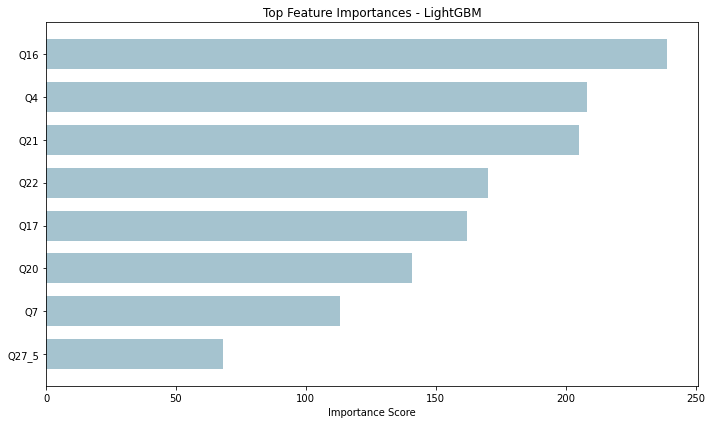


--- LightGBM on PCA Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8890
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

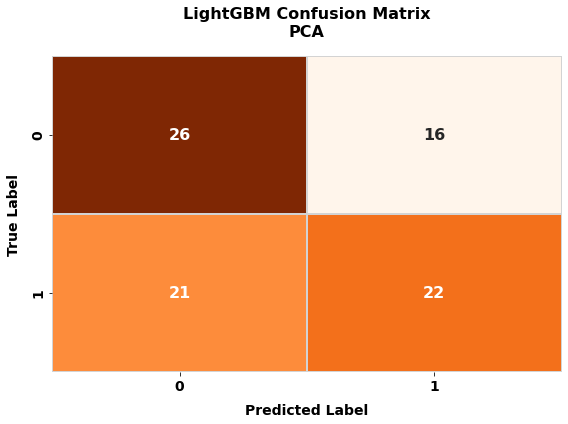

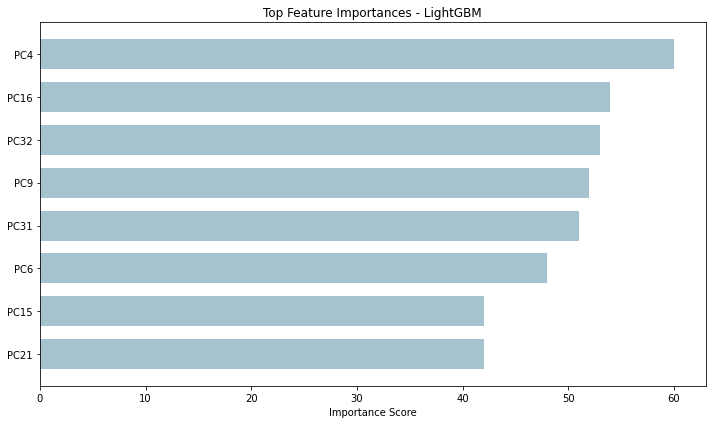


--- LightGBM on PLS Dataset ---
[LightGBM] [Info] Number of positive: 358, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 761, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

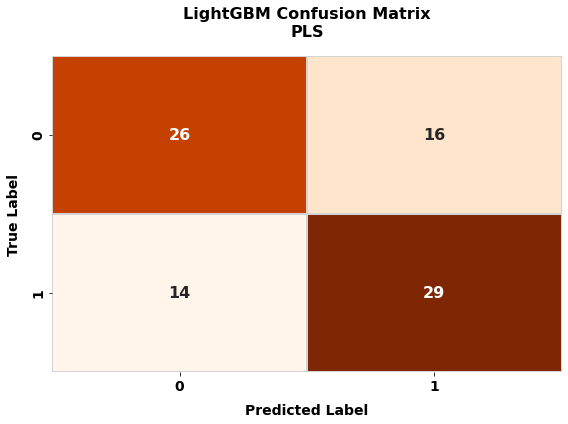

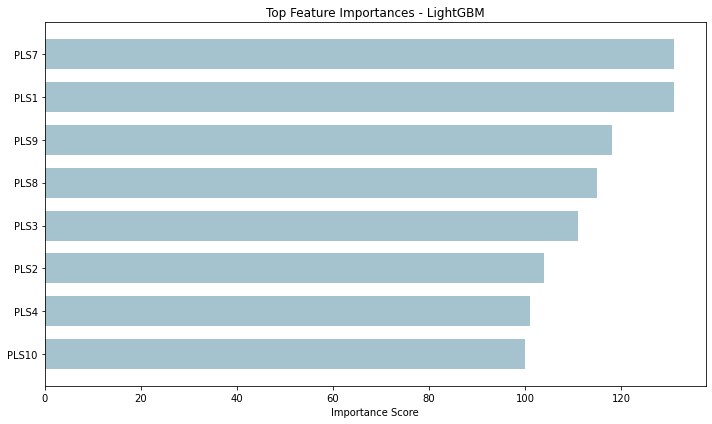

FINAL ACCURACY SUMMARY

Logistic Regression:
  Original       : 0.6471
  Scaled         : 0.6588
  Selected       : 0.6824
  Forward selection: 0.5765
  Domain         : 0.5647
  PCA            : 0.6235
  PLS            : 0.6588

SVM:
  Original       : 0.6118
  Scaled         : 0.6235
  Selected       : 0.6471
  Forward selection: 0.6000
  Domain         : 0.5412
  PCA            : 0.6000
  PLS            : 0.7059

Random Forest:
  Original       : 0.6353
  Scaled         : 0.6235
  Selected       : 0.5765
  Forward selection: 0.5529
  Domain         : 0.4941
  PCA            : 0.5647
  PLS            : 0.6824

XGBoost:
  Original       : 0.6235
  Scaled         : 0.6235
  Selected       : 0.5765
  Forward selection: 0.5765
  Domain         : 0.5294
  PCA            : 0.5529
  PLS            : 0.6706

LightGBM:
  Original       : 0.5882
  Scaled         : 0.5882
  Selected       : 0.5294
  Forward selection: 0.5882
  Domain         : 0.5765
  PCA            : 0.5647
  PLS            :

In [12]:
#----------------------------------------------------------------MODELS FUNCTIONS------------------------------------------------

def run_logistic_regression(X_train, y_train, X_test, y_test, 
                          max_iter = 100000, solver = 'saga', C = 0.01, 
                          class_weight = 'balanced', dataset_name = ''):
    """Logistic regression model."""
    model = LogisticRegression(max_iter = max_iter, solver = solver, 
                             C = C, class_weight = class_weight)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print('Logistic Regression Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    plot_confusion_matrix(y_test, preds, 'Logistic Regression', dataset_name)
    
    # Feature importance plot
    if hasattr(model, 'coef_') and hasattr(X_train, 'columns'):
        importances = np.abs(model.coef_[0])
        plot_feature_importance(importances, X_train, "Logistic Regression")
    
    return model, preds, accuracy

def run_svm(X_train, y_train, X_test, y_test, kernel = 'rbf', 
           class_weight = 'balanced', probability=True, dataset_name = ''):
    """SVM model."""
    model = SVC(kernel = kernel, class_weight = class_weight, probability = probability)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print('SVM Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    plot_confusion_matrix(y_test, preds, 'SVM', dataset_name)
    
    if hasattr(X_train, 'columns'):
        result = permutation_importance(model, X_test, y_test, 
                                      n_repeats=10, random_state=42)
        plot_feature_importance(result.importances_mean, X_train, "SVM")
    
    return model, preds, accuracy

def run_random_forest(X_train, y_train, X_test, y_test, n_estimators = 100, 
                     max_depth = 12, max_features = 'sqrt', min_samples_leaf = 3, 
                     min_samples_split = 2, random_state = 42, dataset_name = ''):
    """Random Forest model."""
    model = RandomForestClassifier(
        n_estimators = n_estimators, max_depth = max_depth, max_features = max_features,
        min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split,
        random_state = random_state
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print('Random Forest Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    plot_confusion_matrix(y_test, preds, "Random Forest", dataset_name)
    plot_feature_importance(model.feature_importances_, X_train, "Random Forest")
    
    return model, preds, accuracy

def run_xgboost(X_train, y_train, X_test, y_test, learning_rate = 0.1, 
               max_depth = 3, min_child_weight = 1, subsample = 0.8, 
               colsample_bytree = 0.8, n_estimators = 100, gamma = 0, 
               random_state = 42, dataset_name = ''):
    """XGBoost model."""
    model = XGBClassifier(
        learning_rate = learning_rate, max_depth = max_depth, 
        min_child_weight = min_child_weight, subsample = subsample,
        colsample_bytree = colsample_bytree, n_estimators = n_estimators,
        gamma=gamma, random_state = random_state, eval_metric = 'logloss',
        use_label_encoder = False
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print('XGBoost Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    plot_confusion_matrix(y_test, preds, "XGBoost", dataset_name)
    plot_feature_importance(model.feature_importances_, X_train, "XGBoost")
    
    return model, preds, accuracy

def run_lightgbm(X_train, y_train, X_test, y_test, n_estimators = 100, 
                learning_rate = 0.1, max_depth = 5, num_leaves = 31, 
                class_weight = 'balanced', random_state = 42, dataset_name = ''):
    """LightGBM model."""
    model = LGBMClassifier(
        n_estimators = n_estimators, learning_rate = learning_rate,
        max_depth = max_depth, num_leaves = num_leaves,
        class_weight = class_weight, random_state = random_state
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    
    print("LightGBM Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))
    
    plot_confusion_matrix(y_test, preds, "LightGBM", dataset_name)
    plot_feature_importance(model.feature_importances_, X_train, "LightGBM")
    
    return model, preds, accuracy

#------------------------------------------------------------PLOTS-------------------------------------------------------------

def plot_confusion_matrix(y_true, y_pred, model_name, dataset_name):
    """Universal confusion matrix plot for all models."""
    plt.figure(figsize = (8, 6))
    cm = confusion_matrix(y_true, y_pred)
    
    if 'Random Forest' in model_name:
        cmap = 'Oranges'
        bg_color = '#f5f5f5'
    elif 'XGBoost' in model_name:
        cmap = 'Oranges'
        bg_color = '#f0f8ff'
    elif 'LightGBM' in model_name:
        cmap = 'Oranges'
        bg_color = '#fffaf0'
    else:  # Logistic Regression, SVM
        cmap = 'Reds'
        bg_color = None
    
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=cmap,
        annot_kws={'size': 16, 'weight': 'bold'},
        cbar=False,            
        linewidths=1,          
        linecolor='lightgray'   
    )
    
    plt.title(
        f'{model_name} Confusion Matrix\n{dataset_name}', 
        pad=20, fontsize=16, weight='bold'
    )
    plt.xlabel('Predicted Label', fontsize=14, weight='bold', labelpad=10)
    plt.ylabel('True Label', fontsize=14, weight='bold', labelpad=10)
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, weight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, weight='bold')
    
    if bg_color:
        plt.gca().set_facecolor(bg_color)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances, X_train, model_name, top_n=8):
    """Universal feature importance plot for all models."""
    # Handle both DataFrame and numpy array cases
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
    
    # Sort features by importance
    sorted_indices = np.argsort(importances)[::-1]
    n_features = min(top_n, len(feature_names))
    top_indices = sorted_indices[:n_features]
    
    # Choose colors based on model type
    if 'Random Forest' in model_name or 'XGBoost' in model_name or 'LightGBM' in model_name:
        color = '#A5C3CF'
    else:  # Logistic Regression, SVM
        color = '#AC3E3E'
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Top Feature Importances - {model_name}")
    plt.barh(range(n_features), importances[top_indices], 
             align='center', color=color, height=0.7)
    plt.yticks(range(n_features), np.array(feature_names)[top_indices])
    
    # Customize x-label based on model type
    if 'SVM' in model_name:
        plt.xlabel("Mean Accuracy Decrease After Permutation")
    elif any(tree_model in model_name for tree_model in ['Random Forest', 'XGBoost', 'LightGBM']):
        plt.xlabel("Importance Score")
    else:  # Logistic Regression
        plt.xlabel("Absolute Coefficient Value")
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    
#----------------------------------------------------------------RUN FUNCTIONS--------------------------------------------------

datasets = [
    ('Original', X_train, y_train, X_test, y_test),
    ('Scaled', X_train_scaled, y_train, X_test_scaled, y_test),
    ('Selected', X_train_selected, y_train, X_test_selected, y_test),
    ('Forward selection', X_train_FS, y_train, X_test_FS, y_test),
    ('Domain', X_train_domain, y_train, X_test_domain, y_test),
    ('PCA', X_train_pca, y_train, X_test_pca, y_test),
    ('PLS', X_train_pls, y_train, X_test_pls, y_test)
]

model_functions = {
    'Logistic Regression': run_logistic_regression,
    'SVM': run_svm,
    'Random Forest': run_random_forest,
    'XGBoost': run_xgboost,
    'LightGBM': run_lightgbm
}


all_accuracies = {model_name: {} for model_name in model_functions.keys()}

#Run all models on all datasets
for model_name, model_func in model_functions.items():
    
    print(f"RUNNING {model_name.upper()} MODELS")
    
    for dataset_name, X_tr, y_tr, X_te, y_te in datasets:
        print(f"\n--- {model_name} on {dataset_name} Dataset ---")
        try:
            _, _, acc = model_func(X_tr, y_tr, X_te, y_te, dataset_name=dataset_name)
            all_accuracies[model_name][dataset_name] = acc
        except Exception as e:
            print(f"Error running {model_name} on {dataset_name}: {str(e)}")
            all_accuracies[model_name][dataset_name] = 0.0

print("FINAL ACCURACY SUMMARY")

for model_name in all_accuracies:
    print(f"\n{model_name}:")
    for dataset_name, acc in all_accuracies[model_name].items():
        print(f"  {dataset_name:15}: {acc:.4f}")

#Best perfoming model
best_acc = 0
best_combo = ""
for model_name in all_accuracies:
    for dataset_name, acc in all_accuracies[model_name].items():
        if acc > best_acc:
            best_acc = acc
            best_combo = f"{model_name} on {dataset_name}"

print(f"\nBest Performance: {best_combo} with accuracy {best_acc:.4f}")